In [1]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [13]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [14]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [15]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('C:/Users/Student/Documents/123/vic/oringinal-data/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('C:/Users/Student/Documents/123/vic/oringinal-data/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    docs = [_f for _f in df.columns if 'FLAG_DOC' in _f]
    live = [_f for _f in df.columns if ('FLAG_' in _f) & ('FLAG_DOC' not in _f) & ('_FLAG_' not in _f)]
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)

    inc_by_org = df[['AMT_INCOME_TOTAL', 'ORGANIZATION_TYPE']].groupby('ORGANIZATION_TYPE').median()['AMT_INCOME_TOTAL']

    df['NEW_CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
    df['NEW_CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    df['NEW_DOC_IND_KURT'] = df[docs].kurtosis(axis=1)
    df['NEW_LIVE_IND_SUM'] = df[live].sum(axis=1)
    df['NEW_INC_PER_CHLD'] = df['AMT_INCOME_TOTAL'] / (1 + df['CNT_CHILDREN'])
    df['NEW_INC_BY_ORG'] = df['ORGANIZATION_TYPE'].map(inc_by_org)
    df['NEW_EMPLOY_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['NEW_ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / (1 + df['AMT_INCOME_TOTAL'])
    df['NEW_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['NEW_EXT_SOURCES_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    df['NEW_SCORES_STD'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    df['NEW_SCORES_STD'] = df['NEW_SCORES_STD'].fillna(df['NEW_SCORES_STD'].mean())
    df['NEW_CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
    df['NEW_CAR_TO_EMPLOY_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
    df['NEW_PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
    df['NEW_PHONE_TO_EMPLOY_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_EMPLOYED']
    df['NEW_CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

In [16]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('C:/Users/Student/Documents/123/vic/oringinal-data/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('C:/Users/Student/Documents/123/vic/oringinal-data/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    cols = active_agg.columns.tolist()
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    
    for e in cols:
        bureau_agg['NEW_RATIO_BURO_' + e[0] + "_" + e[1].upper()] = bureau_agg['ACTIVE_' + e[0] + "_" + e[1].upper()] / bureau_agg['CLOSED_' + e[0] + "_" + e[1].upper()]
    
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg


In [17]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('C:/Users/Student/Documents/123/vic/oringinal-data/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    cols = approved_agg.columns.tolist()
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    
    for e in cols:
        prev_agg['NEW_RATIO_PREV_' + e[0] + "_" + e[1].upper()] = prev_agg['APPROVED_' + e[0] + "_" + e[1].upper()] / prev_agg['REFUSED_' + e[0] + "_" + e[1].upper()]
    
    gc.collect()
    return prev_agg

In [18]:
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('C:/Users/Student/Documents/123/vic/oringinal-data/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [19]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('C:/Users/Student/Documents/123/vic/oringinal-data/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [20]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('C:/Users/Student/Documents/123/vic/oringinal-data/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [21]:
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.01,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            subsample_freq=1,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=60 , # 39.3259775,
            random_state=0,
            silent=-1,
            verbose=-1, )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 100, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

In [22]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')


In [23]:
def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    with timer("Run LightGBM with kfold"):
        feat_importance = kfold_lightgbm(df, num_folds= 10, stratified= False, debug= debug)


Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 143)
Process bureau and bureau_balance - done in 25s
Previous applications df shape: (338857, 279)
Process previous_applications - done in 29s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 15s
Installments payments df shape: (339587, 26)
Process installments payments - done in 33s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 21s
Starting LightGBM. Train shape: (307507, 866), test shape: (48744, 866)
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.775822	valid_1's auc: 0.763623
[200]	training's auc: 0.798028	valid_1's auc: 0.777931
[300]	training's auc: 0.811503	valid_1's auc: 0.784009
[400]	training's auc: 0.821809	valid_1's auc: 0.787299
[500]	training's auc: 0.830192	valid_1's auc: 0.789019
[600]	training's auc: 0.837252	valid_1's auc: 0.790318
[700]	training's auc: 0.844254	valid_1's auc: 0.791327
[800]	training

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Run LightGBM with kfold - done in 2559s
Full model run - done in 2691s


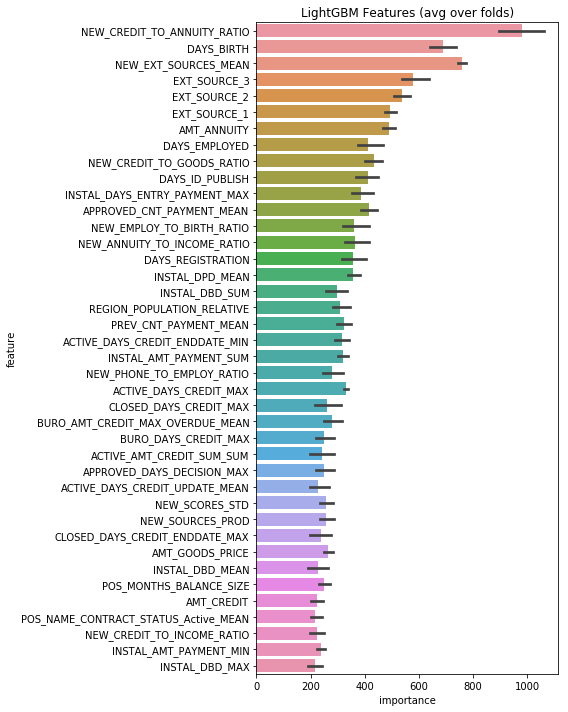

In [41]:
if __name__ == "__main__":
    submission_file_name = "submission_kernel02.csv"
    with timer("Full model run"):
        main()

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 143)
Process bureau and bureau_balance - done in 26s
Previous applications df shape: (338857, 279)
Process previous_applications - done in 30s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 16s
Installments payments df shape: (339587, 26)
Process installments payments - done in 33s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 21s
Starting LightGBM. Train shape: (307507, 871), test shape: (48744, 871)
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.75983	valid_1's auc: 0.753456
[200]	training's auc: 0.774986	valid_1's auc: 0.764822
[300]	training's auc: 0.787207	valid_1's auc: 0.773062
[400]	training's auc: 0.796339	valid_1's auc: 0.778943
[500]	training's auc: 0.80337	valid_1's auc: 0.782831
[600]	training's auc: 0.809174	valid_1's auc: 0.785573
[700]	training's auc: 0.814193	valid_1's auc: 0.787582
[800]	training's

[2600]	training's auc: 0.870655	valid_1's auc: 0.795489
[2700]	training's auc: 0.872766	valid_1's auc: 0.795595
[2800]	training's auc: 0.874827	valid_1's auc: 0.79555
Early stopping, best iteration is:
[2695]	training's auc: 0.872648	valid_1's auc: 0.795612
Fold  4 AUC : 0.795626
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.758957	valid_1's auc: 0.75203
[200]	training's auc: 0.77464	valid_1's auc: 0.764473
[300]	training's auc: 0.787095	valid_1's auc: 0.773779
[400]	training's auc: 0.796046	valid_1's auc: 0.780074
[500]	training's auc: 0.802956	valid_1's auc: 0.784159
[600]	training's auc: 0.80876	valid_1's auc: 0.787162
[700]	training's auc: 0.813735	valid_1's auc: 0.789155
[800]	training's auc: 0.818318	valid_1's auc: 0.790719
[900]	training's auc: 0.822354	valid_1's auc: 0.791978
[1000]	training's auc: 0.826376	valid_1's auc: 0.793066
[1100]	training's auc: 0.829959	valid_1's auc: 0.793896
[1200]	training's auc: 0.833383	valid_1's auc: 0.794

[2500]	training's auc: 0.868308	valid_1's auc: 0.791385
[2600]	training's auc: 0.870481	valid_1's auc: 0.791557
[2700]	training's auc: 0.872537	valid_1's auc: 0.79168
[2800]	training's auc: 0.874628	valid_1's auc: 0.791811
[2900]	training's auc: 0.876643	valid_1's auc: 0.79191
[3000]	training's auc: 0.878625	valid_1's auc: 0.79212
[3100]	training's auc: 0.880545	valid_1's auc: 0.792152
[3200]	training's auc: 0.882506	valid_1's auc: 0.792308
[3300]	training's auc: 0.884586	valid_1's auc: 0.792375
[3400]	training's auc: 0.886455	valid_1's auc: 0.792446
[3500]	training's auc: 0.888253	valid_1's auc: 0.792502
[3600]	training's auc: 0.890144	valid_1's auc: 0.792535
[3700]	training's auc: 0.891782	valid_1's auc: 0.792625
[3800]	training's auc: 0.893377	valid_1's auc: 0.792611
[3900]	training's auc: 0.895004	valid_1's auc: 0.792673
[4000]	training's auc: 0.896779	valid_1's auc: 0.79273
[4100]	training's auc: 0.898458	valid_1's auc: 0.792757
[4200]	training's auc: 0.899978	valid_1's auc: 0.792

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Run LightGBM with kfold - done in 12600s
Full model run - done in 12734s


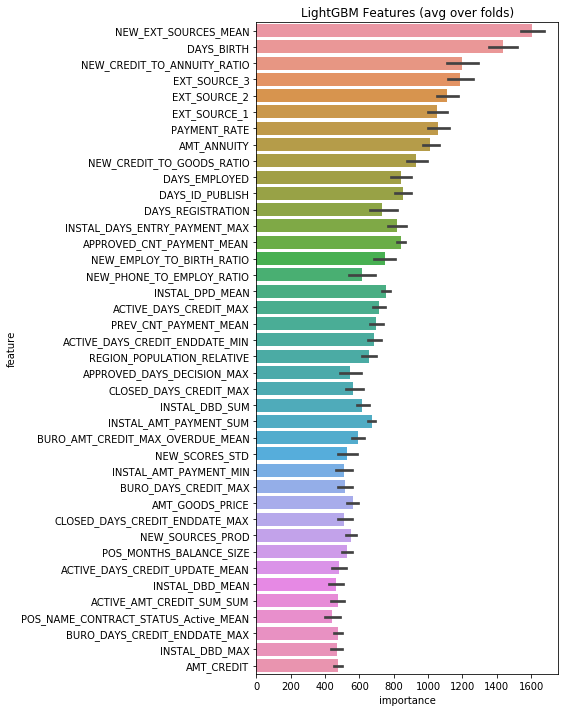

In [24]:
if __name__ == "__main__":
    submission_file_name = "submission_kernel02.csv"
    with timer("Full model run"):
        main()

3.0

In [2]:
full=pd.read_csv('C:/Users/Student/Documents/123/vic/oliver_way/full.csv',index_col=0)
full.head(5)

index  AMT_ANNUITY  AMT_CREDIT  AMT_GOODS_PRICE  AMT_INCOME_TOTAL  \
0      0      24700.5    406597.5         351000.0          202500.0   
1      1      35698.5   1293502.5        1129500.0          270000.0   
2      2       6750.0    135000.0         135000.0           67500.0   
3      3      29686.5    312682.5         297000.0          135000.0   
4      4      21865.5    513000.0         513000.0          121500.0   

   AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_HOUR  \
0                        0.0                         0.0   
1                        0.0                         0.0   
2                        0.0                         0.0   
3                        NaN                         NaN   
4                        0.0                         0.0   

   AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        NaN                        NaN   
4                        0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK    ...     CC_NAME_CONTRACT_STATUS_Signed_MAX  \
0                         0.0    ...                                    NaN   
1                         0.0    ...                                    NaN   
2                         0.0    ...                                    NaN   
3                         NaN    ...                                    0.0   
4                         0.0    ...                                    NaN   

   CC_NAME_CONTRACT_STATUS_Signed_MEAN  CC_NAME_CONTRACT_STATUS_Signed_SUM  \
0                                  NaN                                 NaN   
1                                  NaN                                 NaN   
2                                  NaN                                 NaN   
3                                  0.0                                 0.0   
4                                  NaN                                 NaN   

   CC_NAME_CONTRACT_STATUS_Signed_VAR  CC_NAME_CONTRACT_STATUS_nan_MIN  \
0                                 NaN                              NaN   
1                                 NaN                              NaN   
2                                 NaN                              NaN   
3                                 0.0                              0.0   
4                                 NaN                              NaN   

   CC_NAME_CONTRACT_STATUS_nan_MAX  CC_NAME_CONTRACT_STATUS_nan_MEAN  \
0                              NaN                               NaN   
1                              NaN                               NaN   
2                              NaN                               NaN   
3                              0.0                               0.0   
4                              NaN                               NaN   

   CC_NAME_CONTRACT_STATUS_nan_SUM  CC_NAME_CONTRACT_STATUS_nan_VAR  CC_COUNT  
0                              NaN                              NaN       NaN  
1                              NaN                              NaN       NaN  
2                              NaN                              NaN       NaN  
3                              0.0                              0.0       6.0  
4                              NaN                              NaN       NaN  

[5 rows x 866 columns]

In [3]:
train = full[full['TARGET'].notnull()]
test = full[full['TARGET'].isnull()]

In [5]:
train_missing = (train.isnull().sum() / len(train)).sort_values(ascending = False)

NEW_RATIO_BURO_AMT_CREDIT_SUM_OVERDUE_MEAN    0.990651
NEW_RATIO_BURO_CREDIT_DAY_OVERDUE_MEAN        0.990612
NEW_RATIO_BURO_CREDIT_DAY_OVERDUE_MAX         0.990612
NEW_RATIO_BURO_CNT_CREDIT_PROLONG_SUM         0.975828
NEW_RATIO_BURO_MONTHS_BALANCE_MAX_MAX         0.956925
NEW_RATIO_PREV_AMT_DOWN_PAYMENT_MIN           0.924642
NEW_RATIO_PREV_RATE_DOWN_PAYMENT_MIN          0.924642
NEW_RATIO_PREV_AMT_DOWN_PAYMENT_MAX           0.879505
NEW_RATIO_PREV_AMT_DOWN_PAYMENT_MEAN          0.879505
NEW_RATIO_PREV_RATE_DOWN_PAYMENT_MAX          0.879505
NEW_RATIO_PREV_RATE_DOWN_PAYMENT_MEAN         0.879505
NEW_RATIO_BURO_AMT_ANNUITY_MEAN               0.870474
NEW_RATIO_BURO_AMT_ANNUITY_MAX                0.870474
NEW_RATIO_BURO_AMT_CREDIT_SUM_LIMIT_MEAN      0.867691
NEW_RATIO_BURO_AMT_CREDIT_MAX_OVERDUE_MEAN    0.867203
NEW_RATIO_PREV_APP_CREDIT_PERC_VAR            0.859408
NEW_RATIO_BURO_AMT_CREDIT_SUM_LIMIT_SUM       0.856602
REFUSED_RATE_DOWN_PAYMENT_MEAN                0.853116
REFUSED_RA

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001A762B8DB00>],
      dtype=object)

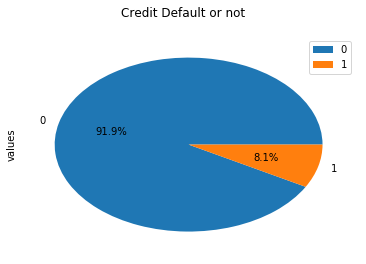

In [33]:
temp = train["TARGET"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
df.plot(kind='pie',x='labels',y='values', title='Credit Default or not',subplots=True,autopct='%2.1f%%')

In [23]:
ext_data =train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

TARGET  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH
TARGET        1.000000     -0.155317     -0.160471     -0.178926    0.078242
EXT_SOURCE_1 -0.155317      1.000000      0.213982      0.186845   -0.600621
EXT_SOURCE_2 -0.160471      0.213982      1.000000      0.109182   -0.092009
EXT_SOURCE_3 -0.178926      0.186845      0.109182      1.000000   -0.205465
DAYS_BIRTH    0.078242     -0.600621     -0.092009     -0.205465    1.000000

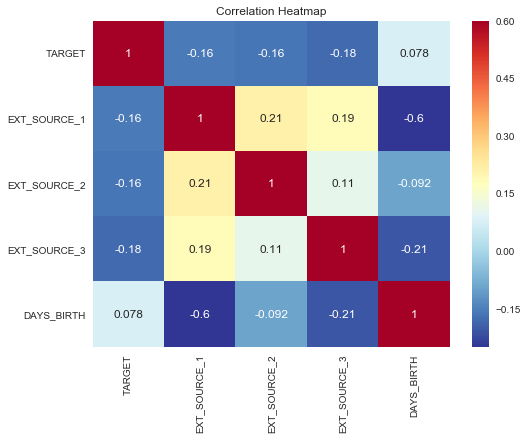

In [24]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

In [2]:
ort=pd.read_csv('C:/Users/Student/Documents/123/vic/oringinal-data/application_train.csv')
orb=pd.read_csv('C:/Users/Student/Documents/123/vic/oringinal-data/bureau.csv')
orbb=pd.read_csv('C:/Users/Student/Documents/123/vic/oringinal-data/bureau_balance.csv')

In [83]:
ort.shape

(307511, 122)

In [81]:
orb.shape

(1716428, 17)

In [4]:
a=pd.read_csv('C:/Users/Student/Documents/123/vic/oringinal-data/previous_application.csv')

In [21]:
aa=a[a['DAYS_FIRST_DRAWING']==365243]
len(aa)

934444

In [22]:
bb=a[a['DAYS_FIRST_DUE']==365243]
len(bb)

40645

In [24]:
cc=a[a['DAYS_LAST_DUE']==365243]
len(cc)

211221

In [31]:
dic={'DAYS_FIRST_DRAWING':len(aa),'DAYS_FIRST_DUE':len(bb),'DAYS_LAST_DUE':len(cc)}

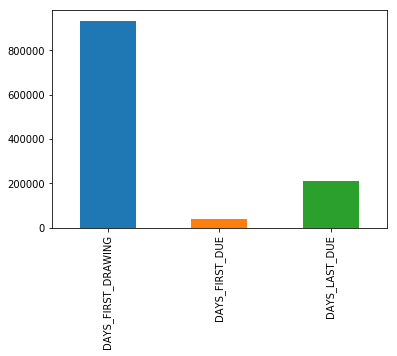

In [32]:
ser=pd.Series(dic)
ser.plot(kind='bar')

In [3]:
train[train.index==380361]

NameError: name 'train' is not defined

In [64]:
train.columns

Index(['index', 'AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE',
       'AMT_INCOME_TOTAL', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       ...
       'CC_NAME_CONTRACT_STATUS_Signed_MAX',
       'CC_NAME_CONTRACT_STATUS_Signed_MEAN',
       'CC_NAME_CONTRACT_STATUS_Signed_SUM',
       'CC_NAME_CONTRACT_STATUS_Signed_VAR', 'CC_NAME_CONTRACT_STATUS_nan_MIN',
       'CC_NAME_CONTRACT_STATUS_nan_MAX', 'CC_NAME_CONTRACT_STATUS_nan_MEAN',
       'CC_NAME_CONTRACT_STATUS_nan_SUM', 'CC_NAME_CONTRACT_STATUS_nan_VAR',
       'CC_COUNT'],
      dtype='object', length=866)

In [4]:
train.columns

Index(['index', 'AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE',
       'AMT_INCOME_TOTAL', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       ...
       'CC_NAME_CONTRACT_STATUS_Signed_MAX',
       'CC_NAME_CONTRACT_STATUS_Signed_MEAN',
       'CC_NAME_CONTRACT_STATUS_Signed_SUM',
       'CC_NAME_CONTRACT_STATUS_Signed_VAR', 'CC_NAME_CONTRACT_STATUS_nan_MIN',
       'CC_NAME_CONTRACT_STATUS_nan_MAX', 'CC_NAME_CONTRACT_STATUS_nan_MEAN',
       'CC_NAME_CONTRACT_STATUS_nan_SUM', 'CC_NAME_CONTRACT_STATUS_nan_VAR',
       'CC_COUNT'],
      dtype='object', length=866)

In [75]:
a=train[train['AMT_ANNUITY']==11871]

In [77]:
b=a[a['AMT_CREDIT']==450000]

In [78]:
b[b['AMT_INCOME_TOTAL']==315000]

index  AMT_ANNUITY  AMT_CREDIT  AMT_GOODS_PRICE  AMT_INCOME_TOTAL  \
217639  217639      11871.0    450000.0         450000.0          315000.0   
242164  242164      11871.0    450000.0         450000.0          315000.0   

        AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_HOUR  \
217639                        0.0                         0.0   
242164                        0.0                         0.0   

        AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  \
217639                        1.0                        0.0   
242164                        0.0                        0.0   

        AMT_REQ_CREDIT_BUREAU_WEEK    ...     \
217639                         0.0    ...      
242164                         0.0    ...      

        CC_NAME_CONTRACT_STATUS_Signed_MAX  \
217639                                 NaN   
242164                                 0.0   

        CC_NAME_CONTRACT_STATUS_Signed_MEAN  \
217639                                  NaN   
242164                                  0.0   

        CC_NAME_CONTRACT_STATUS_Signed_SUM  \
217639                                 NaN   
242164                                 0.0   

        CC_NAME_CONTRACT_STATUS_Signed_VAR  CC_NAME_CONTRACT_STATUS_nan_MIN  \
217639                                 NaN                              NaN   
242164                                 0.0                              0.0   

        CC_NAME_CONTRACT_STATUS_nan_MAX  CC_NAME_CONTRACT_STATUS_nan_MEAN  \
217639                              NaN                               NaN   
242164                              0.0                               0.0   

        CC_NAME_CONTRACT_STATUS_nan_SUM  CC_NAME_CONTRACT_STATUS_nan_VAR  \
217639                              NaN                              NaN   
242164                              0.0                              0.0   

        CC_COUNT  
217639       NaN  
242164      26.0  

[2 rows x 866 columns]

In [5]:
train['BURO_MONTHS_BALANCE_SIZE_SUM']

0          110.0
1            0.0
2            0.0
3            NaN
4            0.0
5            0.0
6            0.0
7           72.0
8            0.0
9            NaN
10           0.0
11           0.0
12           0.0
13           0.0
14           NaN
15          34.0
16           0.0
17           NaN
18           0.0
19           0.0
20           NaN
21           0.0
22           0.0
23           0.0
24           0.0
25           0.0
26           0.0
27          76.0
28           7.0
29           NaN
           ...  
307481     271.0
307482      31.0
307483       0.0
307484       NaN
307485       0.0
307486     385.0
307487      92.0
307488       0.0
307489       7.0
307490     131.0
307491     123.0
307492       0.0
307493       0.0
307494     422.0
307495       0.0
307496       0.0
307497       0.0
307498      17.0
307499       0.0
307500    1118.0
307501       NaN
307502       0.0
307503     320.0
307504       NaN
307505       0.0
307506       NaN
307507       NaN
307508     117

In [99]:
train.loc[:,['BURO_STATUS_0_MEAN_MEAN','BURO_STATUS_1_MEAN_MEAN','BURO_STATUS_2_MEAN_MEAN','BURO_STATUS_3_MEAN_MEAN','BURO_STATUS_4_MEAN_MEAN','BURO_STATUS_5_MEAN_MEAN','BURO_STATUS_C_MEAN_MEAN','BURO_STATUS_X_MEAN_MEAN','BURO_STATUS_nan_MEAN_MEAN']]

BURO_STATUS_0_MEAN_MEAN  BURO_STATUS_1_MEAN_MEAN  \
0                      0.406960                 0.255682   
1                           NaN                      NaN   
2                           NaN                      NaN   
3                           NaN                      NaN   
4                           NaN                      NaN   
5                           NaN                      NaN   
6                           NaN                      NaN   
7                      0.277778                 0.000000   
8                           NaN                      NaN   
9                           NaN                      NaN   
10                          NaN                      NaN   
11                          NaN                      NaN   
12                          NaN                      NaN   
13                          NaN                      NaN   
14                          NaN                      NaN   
15                     0.941176                 0.000000   
16                          NaN                      NaN   
17                          NaN                      NaN   
18                          NaN                      NaN   
19                          NaN                      NaN   
20                          NaN                      NaN   
21                          NaN                      NaN   
22                          NaN                      NaN   
23                          NaN                      NaN   
24                          NaN                      NaN   
25                          NaN                      NaN   
26                          NaN                      NaN   
27                     0.894737                 0.000000   
28                     0.142857                 0.000000   
29                          NaN                      NaN   
...                         ...                      ...   
307481                 0.046782                 0.039290   
307482                 0.920000                 0.000000   
307483                      NaN                      NaN   
307484                      NaN                      NaN   
307485                      NaN                      NaN   
307486                 0.540666                 0.002874   
307487                 0.581451                 0.000000   
307488                      NaN                      NaN   
307489                 1.000000                 0.000000   
307490                 0.134167                 0.134167   
307491                 0.140720                 0.000000   
307492                      NaN                      NaN   
307493                      NaN                      NaN   
307494                 0.057110                 0.000000   
307495                      NaN                      NaN   
307496                      NaN                      NaN   
307497                      NaN                      NaN   
307498                 1.000000                 0.000000   
307499                      NaN                      NaN   
307500                 0.252415                 0.008599   
307501                      NaN                      NaN   
307502                      NaN                      NaN   
307503                 0.325528                 0.000000   
307504                      NaN                      NaN   
307505                      NaN                      NaN   
307506                      NaN                      NaN   
307507                      NaN                      NaN   
307508                 0.404906                 0.000000   
307509                 0.216216                 0.000000   
307510                 0.283249                 0.000000   

        BURO_STATUS_2_MEAN_MEAN  BURO_STATUS_3_MEAN_MEAN  \
0                      0.000000                  0.00000   
1                           NaN                      NaN   
2                           NaN                      NaN   
3                           NaN                

In [3]:
ort['EXT_SOURCE_1']

0         0.083037
1         0.311267
2              NaN
3              NaN
4              NaN
5              NaN
6         0.774761
7              NaN
8         0.587334
9              NaN
10        0.319760
11        0.722044
12        0.464831
13             NaN
14        0.721940
15        0.115634
16             NaN
17             NaN
18             NaN
19             NaN
20        0.565655
21        0.437709
22             NaN
23             NaN
24             NaN
25        0.561948
26             NaN
27             NaN
28        0.600396
29        0.297914
            ...   
307481         NaN
307482    0.470808
307483         NaN
307484         NaN
307485    0.426391
307486         NaN
307487         NaN
307488    0.479458
307489         NaN
307490    0.245623
307491    0.532858
307492         NaN
307493         NaN
307494    0.531969
307495         NaN
307496    0.644797
307497    0.251096
307498         NaN
307499    0.665343
307500    0.896042
307501         NaN
307502      

In [ ]:
df['NEW_EXT_SOURCES_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
df['NEW_CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
df['NEW_CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
df['NEW_EMPLOY_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['NEW_INC_PER_CHLD'] = df['AMT_INCOME_TOTAL'] / (1 + df['CNT_CHILDREN'])

